# **Set up Notebook**

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


# **Load Images from Dataset**

In [6]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [8]:
# load images
images = np.load('pathmnist.npz')

In [9]:
# split data into training set and validation set
x_train = images['train_images']
x_val = images['val_images']
x_test = images['test_images']

y_train = images['train_labels']
y_val = images['val_labels']
y_test = images['test_labels']

# **EDA**

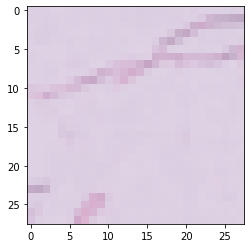

In [11]:
plt.imshow(x_train[0])

In [12]:
print(x_train.shape)
print(y_train.shape)

(89996, 28, 28, 3)
(89996, 1)


In [13]:
print(x_train.max())
print(y_train.max())

255
8


# **Data Preprocessing**

In [15]:
from tensorflow.keras.utils import to_categorical

In [14]:
# normalize image data
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

In [16]:
#one hot encoding
y_cat_train = to_categorical(y_train)
y_cat_val = to_categorical(y_val)
y_cat_test = to_categorical(y_test)

In [17]:
print(y_cat_train.shape)
print(y_cat_val.shape)
print(y_cat_test.shape)

(89996, 9)
(10004, 9)
(7180, 9)


In [18]:
# resize images to be larger
x_train_resized = tf.image.resize(x_train, (32, 32)).numpy()
x_val_resized = tf.image.resize(x_val, (32, 32)).numpy()
x_test_resized = tf.image.resize(x_test, (32, 32)).numpy()

## **Build Model**

In [ ]:
IMG_SHAPE = (32, 32, 3)
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [ ]:
VGG16_MODEL.trainable=True
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(9 ,activation='softmax')

In [ ]:
model = tf.keras.Sequential([
  VGG16_MODEL,
  global_average_layer,
  prediction_layer
])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-05)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 14,719,305
Trainable params: 14,719,305
Non-trainable params: 0
_________________________________________________________________


# **Train Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
mcp = ModelCheckpoint('vgg16model.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='min')

In [ ]:
model.fit(x_train_resized, y_cat_train, 
          epochs=50, 
          validation_data=(x_val_resized, y_cat_val), 
          batch_size=128, 
          callbacks=[early_stopping, mcp, reduce_lr_loss])

Epoch 1/50
704/704 [==============================] - 89s 123ms/step - loss: 1.7280 - accuracy: 0.3345 - val_loss: 1.5678 - val_accuracy: 0.3874 - lr: 1.0000e-05
Epoch 2/50
704/704 [==============================] - 86s 123ms/step - loss: 1.5259 - accuracy: 0.4109 - val_loss: 1.4939 - val_accuracy: 0.4286 - lr: 1.0000e-05
Epoch 3/50
704/704 [==============================] - 86s 122ms/step - loss: 1.4650 - accuracy: 0.4451 - val_loss: 1.4403 - val_accuracy: 0.4603 - lr: 1.0000e-05
Epoch 4/50
704/704 [==============================] - 86s 122ms/step - loss: 1.3896 - accuracy: 0.4822 - val_loss: 1.3525 - val_accuracy: 0.5056 - lr: 1.0000e-05
Epoch 5/50
704/704 [==============================] - 86s 122ms/step - loss: 1.3117 - accuracy: 0.5083 - val_loss: 1.2415 - val_accuracy: 0.5350 - lr: 1.0000e-05
Epoch 6/50
704/704 [==============================] - 86s 123ms/step - loss: 1.1973 - accuracy: 0.5522 - val_loss: 1.1243 - val_accuracy: 0.5881 - lr: 1.0000e-05
Epoch 7/50
704/704 [========

# **Evaluate Model**

In [ ]:
metrics = pd.DataFrame(model.history.history)

In [ ]:
metrics

,loss,accuracy,val_loss,val_accuracy,lr
0,1.727989,0.334548,1.567761,0.387445,1.000000e-05
1,1.525908,0.410907,1.493910,0.428629,1.000000e-05
2,1.465037,0.445086,1.440295,0.460316,1.000000e-05
3,1.389603,0.482177,1.352463,0.505598,1.000000e-05
4,1.311701,0.508312,1.241490,0.534986,1.000000e-05
5,1.197294,0.552236,1.124254,0.588065,1.000000e-05
6,1.097774,0.591715,1.284272,0.511895,1.000000e-05
7,1.030468,0.616383,1.051063,0.599460,1.000000e-05
8,0.982913,0.632761,1.337881,0.486905,1.000000e-05
9,0.933104,0.652540,0.994437,0.614854,1.000000e-05


In [ ]:
metrics.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'], dtype='object')

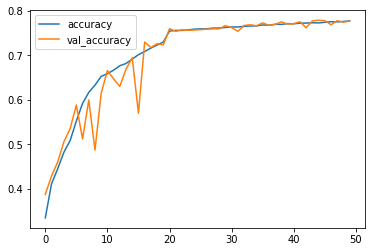

In [ ]:
metrics[['accuracy', 'val_accuracy']].plot()

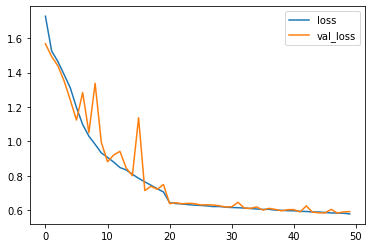

In [ ]:
metrics[['loss', 'val_loss']].plot()

In [ ]:
model.save('mymodel_vgg16.h5')

# **Predicting**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
model = tf.keras.models.load_model('mymodel_vgg16.h5')

In [23]:
y_pred = model.predict(x_test_resized)
y_pred = np.argmax(y_pred,axis=1)

In [28]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1353
           1       1.00      0.87      0.93       972
           2       0.65      0.38      0.48       579
           3       0.75      0.95      0.83       499
           4       0.81      0.86      0.83       974
           5       0.64      0.66      0.65       566
           6       0.55      0.73      0.63       558
           7       0.39      0.56      0.46       293
           8       0.82      0.73      0.78      1386

    accuracy                           0.77      7180
   macro avg       0.72      0.74      0.72      7180
weighted avg       0.79      0.77      0.77      7180



In [29]:
print(confusion_matrix(y_pred, y_test))

[[1206    0    9    0   78   55    1    4    0]
 [  15  847    0    0  108    0    0    2    0]
 [   0    0  219   42    0  120   15  103   80]
 [   0    0    0  473    0    0   19    1    6]
 [  29    0    0    1  837    7   76    6   18]
 [  86    0   19    3    1  376   11   50   20]
 [   0    0    0   58    5    0  410    1   84]
 [   0    0   86    1    3   29    2  164    8]
 [   2    0    6   56    3    5  207   90 1017]]
